In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import optuna

# Prepare Data

In [2]:
# category_2 data
df_train_2 = pd.read_csv("../data/train_prepared_category_2.csv")
df_test_2 = pd.read_csv("../data/test_prepared_category_2.csv")

# category_3 data
df_train_4 = pd.read_csv("../data/train_prepared_category_4.csv")
df_test_4 = pd.read_csv("../data/test_prepared_category_4.csv")

In [24]:
# Keep originals
D2_train = df_train_2.copy()
D2_test = df_test_2.copy()
D4_train = df_train_4.copy()
D4_test = df_test_4.copy()

In [25]:
drop_features_2 = ["Unnamed: 0",
                   "id", 
                   "street", 
                   "address"]

D2_train = D2_train.drop(drop_features_2, axis=1)
D2_test = D2_test.drop(drop_features_2, axis=1)

D2_train = D2_train.drop("price", axis=1)
features_2 = D2_train.columns.values.tolist()

In [26]:
drop_features_4 = ["Unnamed: 0", 
                   "id", 
                   "street", 
                   "address"]


D4_train = D4_train.drop(drop_features_4, axis=1)
D4_test = D4_test.drop(drop_features_4, axis=1)

D4_train = D4_train.drop("price", axis=1)
features_4 = D4_train.columns.values.tolist()

In [27]:
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

imp1 = imputor.fit_transform(D2_train)
imp2 = imputor.fit_transform(D2_test)

In [28]:
D2_train = pd.DataFrame(imp1, columns=features_2)
D2_test = pd.DataFrame(imp2, columns=features_2)

In [29]:
# Log prices
y_train_2 = df_train_2["price"].copy()
y_train_4 = df_train_4["price"].copy()

y_train_2 = np.log(y_train_2)
y_train_4 = np.log(y_train_4)

In [30]:
D2_train.head()

,area_total,area_kitchen,area_living,floor,rooms,ceiling,building_id,latitude,longitude,district,...,phones_0.0,phones_1.0,phones_2.0,phones_nan,parking_0.0,parking_1.0,parking_2.0,parking_nan,elevator,elevator_no
0,-0.259939,-0.007962,-0.246552,2.0,2.0,-0.057242,4076.0,55.817557,37.732359,3.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.230930,0.250960,0.294875,18.0,3.0,0.000000,1893.0,55.725133,37.775263,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.069012,1.515108,0.065565,12.0,3.0,-0.057242,5176.0,55.725133,37.775263,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.230930,0.220498,0.294875,18.0,3.0,0.000000,1893.0,55.725133,37.775263,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.060489,0.677419,-0.119158,7.0,2.0,-0.034100,6604.0,55.734643,37.698798,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [31]:
D4_train.head()

,area_total,area_kitchen,area_living,floor,rooms,ceiling,building_id,latitude,longitude,district,...,phones_0.0,phones_1.0,phones_2.0,phones_nan,parking_0.0,parking_1.0,parking_2.0,parking_nan,elevator,elevator_no
0,-0.259939,-0.007962,-0.246552,2.0,2.0,-0.057242,4076,55.817557,37.732359,3,...,0,1,0,0,0,1,0,0,1,0
1,0.230930,0.250960,0.294875,18.0,3.0,0.000000,1893,55.725133,37.775263,4,...,0,1,0,0,0,1,0,0,1,0
2,0.069012,1.515108,0.065565,12.0,3.0,-0.057242,5176,55.725133,37.775263,4,...,0,1,0,0,0,1,0,0,1,0
3,0.230930,0.220498,0.294875,18.0,3.0,0.000000,1893,55.725133,37.775263,4,...,0,1,0,0,0,1,0,0,1,0
4,0.060489,0.677419,-0.119158,7.0,2.0,-0.034100,6604,55.734643,37.698798,4,...,0,1,0,0,0,1,0,0,1,0


# Prepare Analysis

In [35]:
X = D4_train.copy()
y = y_train_4.copy()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

# Test Models

# Hyperparameter testing on cateogry_4 data and LGBM

In [37]:
def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 50, 74)
    max_depth = trial.suggest_int('max_depth', 60, 100)
    n_jobs = trial.suggest_int('n_jobs', 3, 7)
    n_estimators = trial.suggest_int('n_estimators', 3500, 4120)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.44, 0.64)
    subsample = trial.suggest_uniform('subsample', 0.9, 1)
    learning_rate = trial.suggest_uniform('learning_rate', 0.02, 0.06)

    clf = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth, 
        random_state=42,
        metric='rmse',
        n_jobs=n_jobs, 
        n_estimators=n_estimators,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        learning_rate=learning_rate
    )

    clf.fit(X_train, y_train)
    lgbm_prediction = clf.predict(X_test, num_iteration=clf.best_iteration_)
    lgbm_prediction = np.exp(lgbm_prediction)

    return np.sqrt(mean_squared_log_error(lgbm_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-17 05:26:32,749] A new study created in memory with name: no-name-f4c41883-c4a8-4292-bfd4-4ea7a64a50c2
[I 2021-11-17 05:26:39,012] Trial 0 finished with value: 13.62014938714359 and parameters: {'num_leaves': 51, 'max_depth': 63, 'n_jobs': 7, 'n_estimators': 3522, 'colsample_bytree': 0.44139646449297226, 'subsample': 0.946303054098727, 'learning_rate': 0.04852514438561674}. Best is trial 0 with value: 13.62014938714359.
[I 2021-11-17 05:26:46,973] Trial 1 finished with value: 13.619212670375967 and parameters: {'num_leaves': 72, 'max_depth': 85, 'n_jobs': 3, 'n_estimators': 3580, 'colsample_bytree': 0.5664952944803912, 'subsample': 0.9280733859617883, 'learning_rate': 0.03580110100489507}. Best is trial 1 with value: 13.619212670375967.
[I 2021-11-17 05:26:53,012] Trial 2 finished with value: 13.620224522018399 and parameters: {'num_leaves': 56, 'max_depth': 87, 'n_jobs': 4, 'n_estimators': 3633, 'colsample_bytree': 0.46181445833606805, 'subsample': 0.9859107079881435, 'lear

[I 2021-11-17 05:30:52,095] Trial 24 finished with value: 13.619508706312807 and parameters: {'num_leaves': 67, 'max_depth': 82, 'n_jobs': 7, 'n_estimators': 3886, 'colsample_bytree': 0.6177816791860675, 'subsample': 0.9747210489879596, 'learning_rate': 0.0338005873601399}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:31:04,490] Trial 25 finished with value: 13.620996412369438 and parameters: {'num_leaves': 72, 'max_depth': 71, 'n_jobs': 5, 'n_estimators': 4041, 'colsample_bytree': 0.5955313875029667, 'subsample': 0.9546008119574069, 'learning_rate': 0.04733717098917327}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:31:15,057] Trial 26 finished with value: 13.619385842335358 and parameters: {'num_leaves': 63, 'max_depth': 64, 'n_jobs': 6, 'n_estimators': 3784, 'colsample_bytree': 0.6392517996914199, 'subsample': 0.936770452370679, 'learning_rate': 0.05240546685266197}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:31:25,551]

[I 2021-11-17 05:35:28,128] Trial 49 finished with value: 13.619990324418964 and parameters: {'num_leaves': 71, 'max_depth': 71, 'n_jobs': 6, 'n_estimators': 3835, 'colsample_bytree': 0.5057925579492242, 'subsample': 0.980695066097312, 'learning_rate': 0.046386078582732346}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:35:36,761] Trial 50 finished with value: 13.619551867964827 and parameters: {'num_leaves': 57, 'max_depth': 77, 'n_jobs': 3, 'n_estimators': 3542, 'colsample_bytree': 0.5413800244199418, 'subsample': 0.9881672531316225, 'learning_rate': 0.024087451939516114}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:35:47,258] Trial 51 finished with value: 13.620007223036554 and parameters: {'num_leaves': 70, 'max_depth': 73, 'n_jobs': 6, 'n_estimators': 3678, 'colsample_bytree': 0.5833221433924766, 'subsample': 0.9179827486850725, 'learning_rate': 0.03611516620232954}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:35:57,5

[I 2021-11-17 05:40:02,543] Trial 74 finished with value: 13.619309725558551 and parameters: {'num_leaves': 72, 'max_depth': 82, 'n_jobs': 5, 'n_estimators': 3719, 'colsample_bytree': 0.5868413401841552, 'subsample': 0.9361229390985987, 'learning_rate': 0.037028175974568804}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:40:13,050] Trial 75 finished with value: 13.618995814372209 and parameters: {'num_leaves': 69, 'max_depth': 97, 'n_jobs': 3, 'n_estimators': 3985, 'colsample_bytree': 0.6354754712948391, 'subsample': 0.9210577377887411, 'learning_rate': 0.04066622448145489}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:40:22,840] Trial 76 finished with value: 13.619062603188583 and parameters: {'num_leaves': 67, 'max_depth': 72, 'n_jobs': 3, 'n_estimators': 3973, 'colsample_bytree': 0.6233396132885978, 'subsample': 0.9001736449628435, 'learning_rate': 0.04072446254875022}. Best is trial 14 with value: 13.618660237428708.
[I 2021-11-17 05:40:32,8

[I 2021-11-17 05:44:13,765] Trial 99 finished with value: 13.619767055770312 and parameters: {'num_leaves': 52, 'max_depth': 64, 'n_jobs': 3, 'n_estimators': 4053, 'colsample_bytree': 0.6110683974440078, 'subsample': 0.9969292104382491, 'learning_rate': 0.04273436771969816}. Best is trial 82 with value: 13.61858220363662.


FrozenTrial(number=82, values=[13.61858220363662], datetime_start=datetime.datetime(2021, 11, 17, 5, 41, 13, 561287), datetime_complete=datetime.datetime(2021, 11, 17, 5, 41, 23, 633174), params={'num_leaves': 69, 'max_depth': 70, 'n_jobs': 3, 'n_estimators': 3899, 'colsample_bytree': 0.6286990682337588, 'subsample': 0.9798034302267582, 'learning_rate': 0.04200024249047391}, distributions={'num_leaves': IntUniformDistribution(high=74, low=50, step=1), 'max_depth': IntUniformDistribution(high=100, low=60, step=1), 'n_jobs': IntUniformDistribution(high=7, low=3, step=1), 'n_estimators': IntUniformDistribution(high=4120, low=3500, step=1), 'colsample_bytree': UniformDistribution(high=0.64, low=0.44), 'subsample': UniformDistribution(high=1.0, low=0.9), 'learning_rate': UniformDistribution(high=0.06, low=0.02)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=82, state=TrialState.COMPLETE, value=None)


# Hyperparameter testing on category_2 data with general imputing using LGBM

In [38]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [41]:
def objective_2(trial):
    num_leaves = trial.suggest_int('num_leaves', 50, 74)
    max_depth = trial.suggest_int('max_depth', 60, 100)
    n_jobs = trial.suggest_int('n_jobs', 3, 7)
    n_estimators = trial.suggest_int('n_estimators', 3500, 4120)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.44, 0.64)
    subsample = trial.suggest_uniform('subsample', 0.9, 1)
    learning_rate = trial.suggest_uniform('learning_rate', 0.02, 0.06)

    clf = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth, 
        random_state=42,
        metric='rmse',
        n_jobs=n_jobs, 
        n_estimators=n_estimators,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        learning_rate=learning_rate
    )

    clf.fit(X_train, y_train)
    lgbm_prediction = clf.predict(X_test, num_iteration=clf.best_iteration_)
    lgbm_prediction = np.exp(lgbm_prediction)

    return np.sqrt(mean_squared_log_error(lgbm_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective_2, n_trials=100)
print(study.best_trial)

[I 2021-11-17 08:24:08,906] A new study created in memory with name: no-name-502cce18-8a59-4ee8-9c54-a5a2e617b39d
[I 2021-11-17 08:24:15,307] Trial 0 finished with value: 13.62146011994582 and parameters: {'num_leaves': 65, 'max_depth': 92, 'n_jobs': 4, 'n_estimators': 3891, 'colsample_bytree': 0.4934318677653633, 'subsample': 0.972637533238071, 'learning_rate': 0.03745593898858335}. Best is trial 0 with value: 13.62146011994582.
[I 2021-11-17 08:24:21,777] Trial 1 finished with value: 13.621330480237553 and parameters: {'num_leaves': 57, 'max_depth': 76, 'n_jobs': 3, 'n_estimators': 3978, 'colsample_bytree': 0.5744258446155269, 'subsample': 0.9758779842788561, 'learning_rate': 0.05131533553263205}. Best is trial 1 with value: 13.621330480237553.
[I 2021-11-17 08:24:27,880] Trial 2 finished with value: 13.620497853054463 and parameters: {'num_leaves': 61, 'max_depth': 68, 'n_jobs': 5, 'n_estimators': 3737, 'colsample_bytree': 0.47782449308964015, 'subsample': 0.9841590922757052, 'learn

[I 2021-11-17 08:27:44,459] Trial 24 finished with value: 13.621260478290997 and parameters: {'num_leaves': 59, 'max_depth': 88, 'n_jobs': 6, 'n_estimators': 3822, 'colsample_bytree': 0.4823109059315588, 'subsample': 0.9222097854760553, 'learning_rate': 0.02719740598497972}. Best is trial 13 with value: 13.619755221307663.
[I 2021-11-17 08:27:56,113] Trial 25 finished with value: 13.620979130240046 and parameters: {'num_leaves': 66, 'max_depth': 79, 'n_jobs': 7, 'n_estimators': 4039, 'colsample_bytree': 0.5247389235430128, 'subsample': 0.9283822072498689, 'learning_rate': 0.04168274177486857}. Best is trial 13 with value: 13.619755221307663.
[I 2021-11-17 08:28:06,713] Trial 26 finished with value: 13.62064979637207 and parameters: {'num_leaves': 70, 'max_depth': 73, 'n_jobs': 6, 'n_estimators': 3939, 'colsample_bytree': 0.47185111161799187, 'subsample': 0.9160288568660043, 'learning_rate': 0.032152280149661955}. Best is trial 13 with value: 13.619755221307663.
[I 2021-11-17 08:28:17,5

[I 2021-11-17 08:31:56,613] Trial 49 finished with value: 13.619330180265294 and parameters: {'num_leaves': 72, 'max_depth': 81, 'n_jobs': 4, 'n_estimators': 3654, 'colsample_bytree': 0.4911161772525436, 'subsample': 0.9687535557636561, 'learning_rate': 0.053822488018576274}. Best is trial 46 with value: 13.619120001141733.
[I 2021-11-17 08:32:05,280] Trial 50 finished with value: 13.62167744075867 and parameters: {'num_leaves': 73, 'max_depth': 78, 'n_jobs': 4, 'n_estimators': 3608, 'colsample_bytree': 0.5041807009705491, 'subsample': 0.9649402878886634, 'learning_rate': 0.05438469744791032}. Best is trial 46 with value: 13.619120001141733.
[I 2021-11-17 08:32:15,137] Trial 51 finished with value: 13.620494000958757 and parameters: {'num_leaves': 71, 'max_depth': 82, 'n_jobs': 3, 'n_estimators': 3859, 'colsample_bytree': 0.48719275716746757, 'subsample': 0.9877301242233206, 'learning_rate': 0.04659431761395765}. Best is trial 46 with value: 13.619120001141733.
[I 2021-11-17 08:32:23,9

[I 2021-11-17 08:36:33,003] Trial 74 finished with value: 13.621045571698547 and parameters: {'num_leaves': 71, 'max_depth': 98, 'n_jobs': 7, 'n_estimators': 3663, 'colsample_bytree': 0.4495877352106613, 'subsample': 0.930879569287112, 'learning_rate': 0.04862364668862173}. Best is trial 46 with value: 13.619120001141733.
[I 2021-11-17 08:36:45,122] Trial 75 finished with value: 13.620925514254811 and parameters: {'num_leaves': 73, 'max_depth': 95, 'n_jobs': 7, 'n_estimators': 3548, 'colsample_bytree': 0.4553046613043328, 'subsample': 0.9211278374607574, 'learning_rate': 0.05070868706520662}. Best is trial 46 with value: 13.619120001141733.
[I 2021-11-17 08:36:57,309] Trial 76 finished with value: 13.62037756623556 and parameters: {'num_leaves': 72, 'max_depth': 97, 'n_jobs': 7, 'n_estimators': 3696, 'colsample_bytree': 0.44498769148561335, 'subsample': 0.9385177231278944, 'learning_rate': 0.05420178619947192}. Best is trial 46 with value: 13.619120001141733.
[I 2021-11-17 08:37:08,010

[I 2021-11-17 08:43:15,639] Trial 99 finished with value: 13.620647168295164 and parameters: {'num_leaves': 74, 'max_depth': 66, 'n_jobs': 7, 'n_estimators': 4050, 'colsample_bytree': 0.5091743925720915, 'subsample': 0.9803328834322654, 'learning_rate': 0.05672461440846705}. Best is trial 46 with value: 13.619120001141733.


FrozenTrial(number=46, values=[13.619120001141733], datetime_start=datetime.datetime(2021, 11, 17, 8, 31, 14, 933506), datetime_complete=datetime.datetime(2021, 11, 17, 8, 31, 26, 552655), params={'num_leaves': 69, 'max_depth': 93, 'n_jobs': 7, 'n_estimators': 4030, 'colsample_bytree': 0.47350585383792243, 'subsample': 0.9160561325493849, 'learning_rate': 0.050588237357032724}, distributions={'num_leaves': IntUniformDistribution(high=74, low=50, step=1), 'max_depth': IntUniformDistribution(high=100, low=60, step=1), 'n_jobs': IntUniformDistribution(high=7, low=3, step=1), 'n_estimators': IntUniformDistribution(high=4120, low=3500, step=1), 'colsample_bytree': UniformDistribution(high=0.64, low=0.44), 'subsample': UniformDistribution(high=1.0, low=0.9), 'learning_rate': UniformDistribution(high=0.06, low=0.02)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=46, state=TrialState.COMPLETE, value=None)


# Optimizing XBOOST

# Tuning Category_4 data for XBOOST

In [42]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [43]:
def objective(trial):
    base_score = trial.suggest_uniform('base_score', 0.6, 0.76)
    max_depth = trial.suggest_int('max_depth', 10, 14)
    n_jobs = trial.suggest_int('n_jobs', 14, 18)
    min_child_weight = trial.suggest_int('min_child_weight', 6, 10)
    n_estimators = trial.suggest_int('n_estimators', 1594, 2194)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.7, 0.86)
    subsample = trial.suggest_uniform('subsample', 0.73, 0.9)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.06)

    clf=xgboost.XGBRegressor(base_score=base_score, 
                             booster='gbtree', 
                             colsample_bylevel=1,
                             colsample_bynode=1, 
                             colsample_bytree=colsample_bytree,
                             gamma=0, 
                             gpu_id=-1, 
                             importance_type=None,
                             interaction_constraints='',
                             learning_rate=learning_rate, 
                             max_delta_step=0,
                             max_depth=max_depth, 
                             min_child_weight=min_child_weight,
                             monotone_constraints='()', 
                             n_estimators=n_estimators, 
                             n_jobs=n_jobs,
                             num_parallel_tree=1, 
                             predictor='auto', 
                             random_state=42, 
                             reg_alpha=0,
                             reg_lambda=1, 
                             scale_pos_weight=1, 
                             subsample=subsample, 
                             tree_method='exact',
                             validate_parameters=1, 
                             verbosity=None, 
                             objective='reg:squarederror',
                             enable_categorical=False)

    clf.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_test, np.log(y_test))])
    xgboost_prediction = clf.predict(X_test)
    xgboost_prediction = np.exp(xgboost_prediction)

    return np.sqrt(mean_squared_log_error(xgboost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2021-11-17 10:02:59,855] A new study created in memory with name: no-name-cc4ad62a-4c71-4ed4-bcf4-d27818c85d7d


[0]	validation_0-rmse:15.18294	validation_1-rmse:1.53340
[1]	validation_0-rmse:14.65852	validation_1-rmse:1.00855
[2]	validation_0-rmse:14.15214	validation_1-rmse:0.50272
[3]	validation_0-rmse:13.66329	validation_1-rmse:0.06047
[4]	validation_0-rmse:13.19162	validation_1-rmse:0.46680
[5]	validation_0-rmse:12.73601	validation_1-rmse:0.92190
[6]	validation_0-rmse:12.29621	validation_1-rmse:1.36206
[7]	validation_0-rmse:11.87164	validation_1-rmse:1.78744
[8]	validation_0-rmse:11.46173	validation_1-rmse:2.19793
[9]	validation_0-rmse:11.06604	validation_1-rmse:2.59461
[10]	validation_0-rmse:10.68399	validation_1-rmse:2.97760
[11]	validation_0-rmse:10.31518	validation_1-rmse:3.34719
[12]	validation_0-rmse:9.95928	validation_1-rmse:3.70390
[13]	validation_0-rmse:9.61588	validation_1-rmse:4.04815


[I 2021-11-17 10:03:00,242] Trial 0 finished with value: 0.05711924375974048 and parameters: {'base_score': 0.7222841777220445, 'max_depth': 14, 'n_jobs': 14, 'min_child_weight': 7, 'n_estimators': 2073, 'colsample_bytree': 0.7022103962052652, 'subsample': 0.8857654154723862, 'learning_rate': 0.03458425616992177}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:15.61466	validation_1-rmse:1.96565
[1]	validation_0-rmse:15.42080	validation_1-rmse:1.77153
[2]	validation_0-rmse:15.22935	validation_1-rmse:1.57984
[3]	validation_0-rmse:15.04031	validation_1-rmse:1.39059
[4]	validation_0-rmse:14.85361	validation_1-rmse:1.20373
[5]	validation_0-rmse:14.66923	validation_1-rmse:1.01928
[6]	validation_0-rmse:14.48717	validation_1-rmse:0.83727
[7]	validation_0-rmse:14.30733	validation_1-rmse:0.65764
[8]	validation_0-rmse:14.12972	validation_1-rmse:0.48076
[9]	validation_0-rmse:13.95435	validation_1-rmse:0.30728
[10]	validation_0-rmse:13.78115	validation_1-rmse:0.14159
[11]	validation_0-rmse:13.61010	validation_1-rmse:0.07591
[12]	validation_0-rmse:13.44127	validation_1-rmse:0.22164
[13]	validation_0-rmse:13.27459	validation_1-rmse:0.38477
[14]	validation_0-rmse:13.10981	validation_1-rmse:0.54866
[15]	validation_0-rmse:12.94711	validation_1-rmse:0.71100
[16]	validation_0-rmse:12.78643	validation_1-rmse:0.87156
[17]	validation_0-rmse:1

[I 2021-11-17 10:03:00,787] Trial 1 finished with value: 0.07205614987939839 and parameters: {'base_score': 0.6374359170961835, 'max_depth': 11, 'n_jobs': 15, 'min_child_weight': 10, 'n_estimators': 1852, 'colsample_bytree': 0.8197749943347792, 'subsample': 0.778172561352604, 'learning_rate': 0.012428234068832674}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:15.55368	validation_1-rmse:1.90461
[1]	validation_0-rmse:15.34764	validation_1-rmse:1.69828
[2]	validation_0-rmse:15.14428	validation_1-rmse:1.49458
[3]	validation_0-rmse:14.94364	validation_1-rmse:1.29374
[4]	validation_0-rmse:14.74576	validation_1-rmse:1.09557
[5]	validation_0-rmse:14.55040	validation_1-rmse:0.90019
[6]	validation_0-rmse:14.35766	validation_1-rmse:0.70760
[7]	validation_0-rmse:14.16748	validation_1-rmse:0.51785
[8]	validation_0-rmse:13.97982	validation_1-rmse:0.33171
[9]	validation_0-rmse:13.79465	validation_1-rmse:0.15262
[10]	validation_0-rmse:13.61192	validation_1-rmse:0.07260
[11]	validation_0-rmse:13.43164	validation_1-rmse:0.23055
[12]	validation_0-rmse:13.25380	validation_1-rmse:0.40523
[13]	validation_0-rmse:13.07839	validation_1-rmse:0.57959
[14]	validation_0-rmse:12.90515	validation_1-rmse:0.75258
[15]	validation_0-rmse:12.73432	validation_1-rmse:0.92331
[16]	validation_0-rmse:12.56564	validation_1-rmse:1.09211
[17]	validation_0-rmse:1

[I 2021-11-17 10:03:01,303] Trial 2 finished with value: 0.06890257039795732 and parameters: {'base_score': 0.6859168816337408, 'max_depth': 12, 'n_jobs': 18, 'min_child_weight': 8, 'n_estimators': 1822, 'colsample_bytree': 0.7294034064753295, 'subsample': 0.8556326046124467, 'learning_rate': 0.013263607232574555}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:14.92428	validation_1-rmse:1.27455
[1]	validation_0-rmse:14.05508	validation_1-rmse:0.40670
[2]	validation_0-rmse:13.23641	validation_1-rmse:0.42369
[3]	validation_0-rmse:12.46555	validation_1-rmse:1.19324
[4]	validation_0-rmse:11.74006	validation_1-rmse:1.91968
[5]	validation_0-rmse:11.05653	validation_1-rmse:2.60442
[6]	validation_0-rmse:10.41295	validation_1-rmse:3.24943
[7]	validation_0-rmse:9.80688	validation_1-rmse:3.85691
[8]	validation_0-rmse:9.23613	validation_1-rmse:4.42879
[9]	validation_0-rmse:8.69883	validation_1-rmse:4.96753
[10]	validation_0-rmse:8.19276	validation_1-rmse:5.47514
[11]	validation_0-rmse:7.71629	validation_1-rmse:5.95282


[I 2021-11-17 10:03:01,621] Trial 3 finished with value: 0.3780381116313071 and parameters: {'base_score': 0.600876718364944, 'max_depth': 11, 'n_jobs': 17, 'min_child_weight': 8, 'n_estimators': 2103, 'colsample_bytree': 0.7149162144110148, 'subsample': 0.8874481692146399, 'learning_rate': 0.05831769337031149}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:14.95493	validation_1-rmse:1.30510
[1]	validation_0-rmse:14.22621	validation_1-rmse:0.57668
[2]	validation_0-rmse:13.53300	validation_1-rmse:0.13532
[3]	validation_0-rmse:12.87374	validation_1-rmse:0.78418
[4]	validation_0-rmse:12.24665	validation_1-rmse:1.41182
[5]	validation_0-rmse:11.65014	validation_1-rmse:2.00926
[6]	validation_0-rmse:11.08284	validation_1-rmse:2.57767
[7]	validation_0-rmse:10.54313	validation_1-rmse:3.11856
[8]	validation_0-rmse:10.02976	validation_1-rmse:3.63317
[9]	validation_0-rmse:9.54153	validation_1-rmse:4.12277
[10]	validation_0-rmse:9.07704	validation_1-rmse:4.58858
[11]	validation_0-rmse:8.63529	validation_1-rmse:5.03138


[I 2021-11-17 10:03:01,955] Trial 4 finished with value: 0.12843736222535232 and parameters: {'base_score': 0.727441213955758, 'max_depth': 12, 'n_jobs': 16, 'min_child_weight': 8, 'n_estimators': 1948, 'colsample_bytree': 0.8334427044548811, 'subsample': 0.770032774991795, 'learning_rate': 0.04878480173990938}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:15.27494	validation_1-rmse:1.62549
[1]	validation_0-rmse:14.77924	validation_1-rmse:1.12933
[2]	validation_0-rmse:14.29958	validation_1-rmse:0.64976
[3]	validation_0-rmse:13.83558	validation_1-rmse:0.19230
[4]	validation_0-rmse:13.38687	validation_1-rmse:0.27406
[5]	validation_0-rmse:12.95253	validation_1-rmse:0.70549
[6]	validation_0-rmse:12.53241	validation_1-rmse:1.12573
[7]	validation_0-rmse:12.12585	validation_1-rmse:1.53292
[8]	validation_0-rmse:11.73250	validation_1-rmse:1.92698
[9]	validation_0-rmse:11.35196	validation_1-rmse:2.30839
[10]	validation_0-rmse:10.98380	validation_1-rmse:2.67726
[11]	validation_0-rmse:10.62760	validation_1-rmse:3.03431
[12]	validation_0-rmse:10.28317	validation_1-rmse:3.37952


[I 2021-11-17 10:03:02,320] Trial 5 finished with value: 0.179960770716443 and parameters: {'base_score': 0.6610723979467052, 'max_depth': 13, 'n_jobs': 14, 'min_child_weight': 9, 'n_estimators': 1973, 'colsample_bytree': 0.7910667815394581, 'subsample': 0.7847786127586334, 'learning_rate': 0.03248980781041542}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:15.25097	validation_1-rmse:1.60148
[1]	validation_0-rmse:14.76481	validation_1-rmse:1.11486
[2]	validation_0-rmse:14.29409	validation_1-rmse:0.64444
[3]	validation_0-rmse:13.83846	validation_1-rmse:0.19500
[4]	validation_0-rmse:13.39739	validation_1-rmse:0.26445
[5]	validation_0-rmse:12.97035	validation_1-rmse:0.68802
[6]	validation_0-rmse:12.55702	validation_1-rmse:1.10115
[7]	validation_0-rmse:12.15687	validation_1-rmse:1.50184
[8]	validation_0-rmse:11.76947	validation_1-rmse:1.88983
[9]	validation_0-rmse:11.39447	validation_1-rmse:2.26571
[10]	validation_0-rmse:11.03140	validation_1-rmse:2.62959
[11]	validation_0-rmse:10.68000	validation_1-rmse:2.98183
[12]	validation_0-rmse:10.33996	validation_1-rmse:3.32260


[I 2021-11-17 10:03:02,708] Trial 6 finished with value: 0.18248340382287043 and parameters: {'base_score': 0.6952159519219795, 'max_depth': 12, 'n_jobs': 15, 'min_child_weight': 6, 'n_estimators': 2007, 'colsample_bytree': 0.8594273939212159, 'subsample': 0.8054293314423852, 'learning_rate': 0.031916418850243114}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:15.08895	validation_1-rmse:1.43930
[1]	validation_0-rmse:14.49614	validation_1-rmse:0.84587
[2]	validation_0-rmse:13.92653	validation_1-rmse:0.27940
[3]	validation_0-rmse:13.37934	validation_1-rmse:0.28158
[4]	validation_0-rmse:12.85400	validation_1-rmse:0.80372
[5]	validation_0-rmse:12.34903	validation_1-rmse:1.30924
[6]	validation_0-rmse:11.86400	validation_1-rmse:1.79499
[7]	validation_0-rmse:11.39806	validation_1-rmse:2.26198
[8]	validation_0-rmse:10.95042	validation_1-rmse:2.71062
[9]	validation_0-rmse:10.52048	validation_1-rmse:3.14149
[10]	validation_0-rmse:10.10739	validation_1-rmse:3.55560
[11]	validation_0-rmse:9.71057	validation_1-rmse:3.95330


[I 2021-11-17 10:03:03,031] Trial 7 finished with value: 0.2608317045015925 and parameters: {'base_score': 0.7424159174979315, 'max_depth': 12, 'n_jobs': 17, 'min_child_weight': 8, 'n_estimators': 1634, 'colsample_bytree': 0.7648127802924656, 'subsample': 0.8898990891321016, 'learning_rate': 0.039339196880175877}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:15.29514	validation_1-rmse:1.64571
[1]	validation_0-rmse:14.77908	validation_1-rmse:1.12915
[2]	validation_0-rmse:14.28040	validation_1-rmse:0.63094
[3]	validation_0-rmse:13.79867	validation_1-rmse:0.15875
[4]	validation_0-rmse:13.33342	validation_1-rmse:0.32686
[5]	validation_0-rmse:12.88363	validation_1-rmse:0.77449
[6]	validation_0-rmse:12.44920	validation_1-rmse:1.20901
[7]	validation_0-rmse:12.02929	validation_1-rmse:1.62960
[8]	validation_0-rmse:11.62362	validation_1-rmse:2.03601
[9]	validation_0-rmse:11.23167	validation_1-rmse:2.42892
[10]	validation_0-rmse:10.85292	validation_1-rmse:2.80854
[11]	validation_0-rmse:10.48697	validation_1-rmse:3.17522
[12]	validation_0-rmse:10.13364	validation_1-rmse:3.52937


[I 2021-11-17 10:03:03,338] Trial 8 finished with value: 0.148690378686205 and parameters: {'base_score': 0.6190755703775931, 'max_depth': 12, 'n_jobs': 15, 'min_child_weight': 6, 'n_estimators': 1675, 'colsample_bytree': 0.7267823445404157, 'subsample': 0.7549158656310682, 'learning_rate': 0.03377864759651769}. Best is trial 0 with value: 0.05711924375974048.


[0]	validation_0-rmse:15.66602	validation_1-rmse:2.01709
[1]	validation_0-rmse:15.50596	validation_1-rmse:1.85679
[2]	validation_0-rmse:15.34753	validation_1-rmse:1.69815
[3]	validation_0-rmse:15.19074	validation_1-rmse:1.54116
[4]	validation_0-rmse:15.03556	validation_1-rmse:1.38574
[5]	validation_0-rmse:14.88195	validation_1-rmse:1.23200
[6]	validation_0-rmse:14.72996	validation_1-rmse:1.07993
[7]	validation_0-rmse:14.57947	validation_1-rmse:0.92937
[8]	validation_0-rmse:14.43054	validation_1-rmse:0.78056
[9]	validation_0-rmse:14.28314	validation_1-rmse:0.63339
[10]	validation_0-rmse:14.13724	validation_1-rmse:0.48806
[11]	validation_0-rmse:13.99281	validation_1-rmse:0.34506
[12]	validation_0-rmse:13.84995	validation_1-rmse:0.20545
[13]	validation_0-rmse:13.70852	validation_1-rmse:0.08077
[14]	validation_0-rmse:13.56846	validation_1-rmse:0.10460
[15]	validation_0-rmse:13.42988	validation_1-rmse:0.23261
[16]	validation_0-rmse:13.29271	validation_1-rmse:0.36716
[17]	validation_0-rmse:1

[I 2021-11-17 10:03:03,927] Trial 9 finished with value: 0.07590170550153345 and parameters: {'base_score': 0.6206279900191685, 'max_depth': 13, 'n_jobs': 16, 'min_child_weight': 9, 'n_estimators': 2155, 'colsample_bytree': 0.8404167427486415, 'subsample': 0.7478995170410587, 'learning_rate': 0.010227968272847356}. Best is trial 0 with value: 0.05711924375974048.


FrozenTrial(number=0, values=[0.05711924375974048], datetime_start=datetime.datetime(2021, 11, 17, 10, 2, 59, 858812), datetime_complete=datetime.datetime(2021, 11, 17, 10, 3, 0, 242289), params={'base_score': 0.7222841777220445, 'max_depth': 14, 'n_jobs': 14, 'min_child_weight': 7, 'n_estimators': 2073, 'colsample_bytree': 0.7022103962052652, 'subsample': 0.8857654154723862, 'learning_rate': 0.03458425616992177}, distributions={'base_score': UniformDistribution(high=0.76, low=0.6), 'max_depth': IntUniformDistribution(high=14, low=10, step=1), 'n_jobs': IntUniformDistribution(high=18, low=14, step=1), 'min_child_weight': IntUniformDistribution(high=10, low=6, step=1), 'n_estimators': IntUniformDistribution(high=2194, low=1594, step=1), 'colsample_bytree': UniformDistribution(high=0.86, low=0.7), 'subsample': UniformDistribution(high=0.9, low=0.73), 'learning_rate': UniformDistribution(high=0.06, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=Trial

# Tuning Category_2 autoimputed data for XBOOST

In [44]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [45]:
def objective(trial):
    base_score = trial.suggest_uniform('base_score', 0.6, 0.76)
    max_depth = trial.suggest_int('max_depth', 10, 14)
    n_jobs = trial.suggest_int('n_jobs', 14, 18)
    min_child_weight = trial.suggest_int('min_child_weight', 6, 10)
    n_estimators = trial.suggest_int('n_estimators', 1594, 2194)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.7, 0.86)
    subsample = trial.suggest_uniform('subsample', 0.73, 0.9)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.06)

    clf=xgboost.XGBRegressor(base_score=base_score, 
                             booster='gbtree', 
                             colsample_bylevel=1,
                             colsample_bynode=1, 
                             colsample_bytree=colsample_bytree,
                             gamma=0, 
                             gpu_id=-1, 
                             importance_type=None,
                             interaction_constraints='',
                             learning_rate=learning_rate, 
                             max_delta_step=0,
                             max_depth=max_depth, 
                             min_child_weight=min_child_weight,
                             monotone_constraints='()', 
                             n_estimators=n_estimators, 
                             n_jobs=n_jobs,
                             num_parallel_tree=1, 
                             predictor='auto', 
                             random_state=42, 
                             reg_alpha=0,
                             reg_lambda=1, 
                             scale_pos_weight=1, 
                             subsample=subsample, 
                             tree_method='exact',
                             validate_parameters=1, 
                             verbosity=None, 
                             objective='reg:squarederror',
                             enable_categorical=False)

    clf.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_test, np.log(y_test))])
    xgboost_prediction = clf.predict(X_test)
    xgboost_prediction = np.exp(xgboost_prediction)

    return np.sqrt(mean_squared_log_error(xgboost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2021-11-17 10:06:39,809] A new study created in memory with name: no-name-e45fa63e-3d5d-4cd9-a7b6-7595d0bcef0f


[0]	validation_0-rmse:15.43798	validation_1-rmse:1.78877
[1]	validation_0-rmse:15.10915	validation_1-rmse:1.45937
[2]	validation_0-rmse:14.78722	validation_1-rmse:1.13699
[3]	validation_0-rmse:14.47215	validation_1-rmse:0.82190
[4]	validation_0-rmse:14.16393	validation_1-rmse:0.51411
[5]	validation_0-rmse:13.86223	validation_1-rmse:0.21623
[6]	validation_0-rmse:13.56694	validation_1-rmse:0.10479
[7]	validation_0-rmse:13.27795	validation_1-rmse:0.38151
[8]	validation_0-rmse:12.99512	validation_1-rmse:0.66303
[9]	validation_0-rmse:12.71835	validation_1-rmse:0.93976
[10]	validation_0-rmse:12.44747	validation_1-rmse:1.21088
[11]	validation_0-rmse:12.18239	validation_1-rmse:1.47638
[12]	validation_0-rmse:11.92293	validation_1-rmse:1.73622
[13]	validation_0-rmse:11.66903	validation_1-rmse:1.99057
[14]	validation_0-rmse:11.42051	validation_1-rmse:2.23953
[15]	validation_0-rmse:11.17736	validation_1-rmse:2.48323
[16]	validation_0-rmse:10.93932	validation_1-rmse:2.72177


[I 2021-11-17 10:06:40,175] Trial 0 finished with value: 0.09945101360599343 and parameters: {'base_score': 0.6743469645514621, 'max_depth': 11, 'n_jobs': 14, 'min_child_weight': 6, 'n_estimators': 2170, 'colsample_bytree': 0.7509297891786628, 'subsample': 0.8768306215787991, 'learning_rate': 0.021330425261125465}. Best is trial 0 with value: 0.09945101360599343.


[0]	validation_0-rmse:15.02232	validation_1-rmse:1.37261
[1]	validation_0-rmse:14.25845	validation_1-rmse:0.60856
[2]	validation_0-rmse:13.53325	validation_1-rmse:0.13567
[3]	validation_0-rmse:12.84502	validation_1-rmse:0.81342
[4]	validation_0-rmse:12.19210	validation_1-rmse:1.46696
[5]	validation_0-rmse:11.57235	validation_1-rmse:2.08783
[6]	validation_0-rmse:10.98414	validation_1-rmse:2.67708
[7]	validation_0-rmse:10.42585	validation_1-rmse:3.23664
[8]	validation_0-rmse:9.89607	validation_1-rmse:3.76732
[9]	validation_0-rmse:9.39326	validation_1-rmse:4.27148
[10]	validation_0-rmse:8.91598	validation_1-rmse:4.74982
[11]	validation_0-rmse:8.46315	validation_1-rmse:5.20387
[12]	validation_0-rmse:8.03326	validation_1-rmse:5.63482


[I 2021-11-17 10:06:40,467] Trial 1 finished with value: 0.12878309792393655 and parameters: {'base_score': 0.6209015978197876, 'max_depth': 13, 'n_jobs': 15, 'min_child_weight': 9, 'n_estimators': 2091, 'colsample_bytree': 0.7955758310513072, 'subsample': 0.8529329652879368, 'learning_rate': 0.05092079552569686}. Best is trial 0 with value: 0.09945101360599343.


[0]	validation_0-rmse:14.86120	validation_1-rmse:1.21132
[1]	validation_0-rmse:14.02544	validation_1-rmse:0.37656
[2]	validation_0-rmse:13.23658	validation_1-rmse:0.42247
[3]	validation_0-rmse:12.49223	validation_1-rmse:1.16610
[4]	validation_0-rmse:11.78999	validation_1-rmse:1.86955
[5]	validation_0-rmse:11.12728	validation_1-rmse:2.53370
[6]	validation_0-rmse:10.50185	validation_1-rmse:3.16038
[7]	validation_0-rmse:9.91163	validation_1-rmse:3.75199
[8]	validation_0-rmse:9.35466	validation_1-rmse:4.31000
[9]	validation_0-rmse:8.82911	validation_1-rmse:4.83695
[10]	validation_0-rmse:8.33319	validation_1-rmse:5.33431


[I 2021-11-17 10:06:40,763] Trial 2 finished with value: 0.35044599653582154 and parameters: {'base_score': 0.701343922379986, 'max_depth': 12, 'n_jobs': 14, 'min_child_weight': 8, 'n_estimators': 1742, 'colsample_bytree': 0.7762271346735534, 'subsample': 0.8211864998488431, 'learning_rate': 0.05631511738687484}. Best is trial 0 with value: 0.09945101360599343.


[0]	validation_0-rmse:14.87450	validation_1-rmse:1.22463
[1]	validation_0-rmse:14.06720	validation_1-rmse:0.41789
[2]	validation_0-rmse:13.30352	validation_1-rmse:0.35614
[3]	validation_0-rmse:12.58140	validation_1-rmse:1.07677
[4]	validation_0-rmse:11.89883	validation_1-rmse:1.76051
[5]	validation_0-rmse:11.25329	validation_1-rmse:2.40740
[6]	validation_0-rmse:10.64279	validation_1-rmse:3.01905
[7]	validation_0-rmse:10.06545	validation_1-rmse:3.59778
[8]	validation_0-rmse:9.51957	validation_1-rmse:4.14466
[9]	validation_0-rmse:9.00335	validation_1-rmse:4.66237
[10]	validation_0-rmse:8.51527	validation_1-rmse:5.15186
[11]	validation_0-rmse:8.05382	validation_1-rmse:5.61473
[12]	validation_0-rmse:7.61727	validation_1-rmse:6.05251


[I 2021-11-17 10:06:41,094] Trial 3 finished with value: 0.3391802899430939 and parameters: {'base_score': 0.7200035037365512, 'max_depth': 11, 'n_jobs': 17, 'min_child_weight': 9, 'n_estimators': 1915, 'colsample_bytree': 0.7488380638663094, 'subsample': 0.8594952114365477, 'learning_rate': 0.05435251859247235}. Best is trial 0 with value: 0.09945101360599343.


[0]	validation_0-rmse:15.22669	validation_1-rmse:1.57717
[1]	validation_0-rmse:14.72522	validation_1-rmse:1.07500
[2]	validation_0-rmse:14.24016	validation_1-rmse:0.59003
[3]	validation_0-rmse:13.77113	validation_1-rmse:0.13085
[4]	validation_0-rmse:13.31774	validation_1-rmse:0.34214
[5]	validation_0-rmse:12.87927	validation_1-rmse:0.77886
[6]	validation_0-rmse:12.45521	validation_1-rmse:1.20304
[7]	validation_0-rmse:12.04513	validation_1-rmse:1.61382
[8]	validation_0-rmse:11.64857	validation_1-rmse:2.01086
[9]	validation_0-rmse:11.26511	validation_1-rmse:2.39524
[10]	validation_0-rmse:10.89426	validation_1-rmse:2.76696
[11]	validation_0-rmse:10.53571	validation_1-rmse:3.12638
[12]	validation_0-rmse:10.18897	validation_1-rmse:3.47389
[13]	validation_0-rmse:9.85360	validation_1-rmse:3.81004


[I 2021-11-17 10:06:41,429] Trial 4 finished with value: 0.12267993628135405 and parameters: {'base_score': 0.7030588348887072, 'max_depth': 13, 'n_jobs': 14, 'min_child_weight': 9, 'n_estimators': 2018, 'colsample_bytree': 0.8176806880629403, 'subsample': 0.8303743894577658, 'learning_rate': 0.032977557739032576}. Best is trial 0 with value: 0.09945101360599343.


[0]	validation_0-rmse:15.10047	validation_1-rmse:1.45088
[1]	validation_0-rmse:14.38956	validation_1-rmse:0.73949
[2]	validation_0-rmse:13.71194	validation_1-rmse:0.08407
[3]	validation_0-rmse:13.06629	validation_1-rmse:0.59257
[4]	validation_0-rmse:12.45130	validation_1-rmse:1.20732
[5]	validation_0-rmse:11.86525	validation_1-rmse:1.79428
[6]	validation_0-rmse:11.30677	validation_1-rmse:2.35386
[7]	validation_0-rmse:10.77469	validation_1-rmse:2.88701
[8]	validation_0-rmse:10.26762	validation_1-rmse:3.39513
[9]	validation_0-rmse:9.78454	validation_1-rmse:3.87943
[10]	validation_0-rmse:9.32432	validation_1-rmse:4.34102
[11]	validation_0-rmse:8.88579	validation_1-rmse:4.78062
[12]	validation_0-rmse:8.46781	validation_1-rmse:5.19956


[I 2021-11-17 10:06:41,738] Trial 5 finished with value: 0.07900181674524476 and parameters: {'base_score': 0.6015471378554925, 'max_depth': 14, 'n_jobs': 15, 'min_child_weight': 10, 'n_estimators': 2150, 'colsample_bytree': 0.7558016583333356, 'subsample': 0.8853708391308144, 'learning_rate': 0.04714655811628068}. Best is trial 5 with value: 0.07900181674524476.


[0]	validation_0-rmse:15.39166	validation_1-rmse:1.74238
[1]	validation_0-rmse:14.95260	validation_1-rmse:1.30264
[2]	validation_0-rmse:14.52595	validation_1-rmse:0.87566
[3]	validation_0-rmse:14.11150	validation_1-rmse:0.46237
[4]	validation_0-rmse:13.70905	validation_1-rmse:0.08173
[5]	validation_0-rmse:13.31804	validation_1-rmse:0.34238
[6]	validation_0-rmse:12.93816	validation_1-rmse:0.72020
[7]	validation_0-rmse:12.56914	validation_1-rmse:1.08930
[8]	validation_0-rmse:12.21063	validation_1-rmse:1.44817
[9]	validation_0-rmse:11.86240	validation_1-rmse:1.79699
[10]	validation_0-rmse:11.52416	validation_1-rmse:2.13592
[11]	validation_0-rmse:11.19557	validation_1-rmse:2.46526
[12]	validation_0-rmse:10.87633	validation_1-rmse:2.78513
[13]	validation_0-rmse:10.56624	validation_1-rmse:3.09578
[14]	validation_0-rmse:10.26496	validation_1-rmse:3.39778


[I 2021-11-17 10:06:42,077] Trial 6 finished with value: 0.07682184068627369 and parameters: {'base_score': 0.6046105807010513, 'max_depth': 12, 'n_jobs': 14, 'min_child_weight': 10, 'n_estimators': 1930, 'colsample_bytree': 0.7453234659848241, 'subsample': 0.8964279896477276, 'learning_rate': 0.028564019561400575}. Best is trial 6 with value: 0.07682184068627369.


[0]	validation_0-rmse:15.06821	validation_1-rmse:1.41855
[1]	validation_0-rmse:14.41979	validation_1-rmse:0.76954
[2]	validation_0-rmse:13.79907	validation_1-rmse:0.15612
[3]	validation_0-rmse:13.20517	validation_1-rmse:0.45380
[4]	validation_0-rmse:12.63708	validation_1-rmse:1.02120
[5]	validation_0-rmse:12.09341	validation_1-rmse:1.56559
[6]	validation_0-rmse:11.57311	validation_1-rmse:2.08669
[7]	validation_0-rmse:11.07522	validation_1-rmse:2.58566
[8]	validation_0-rmse:10.59883	validation_1-rmse:3.06293
[9]	validation_0-rmse:10.14301	validation_1-rmse:3.51976
[10]	validation_0-rmse:9.70683	validation_1-rmse:3.95703
[11]	validation_0-rmse:9.28951	validation_1-rmse:4.37544


[I 2021-11-17 10:06:42,367] Trial 7 finished with value: 0.14626884836865883 and parameters: {'base_score': 0.7024003881117586, 'max_depth': 14, 'n_jobs': 14, 'min_child_weight': 8, 'n_estimators': 1989, 'colsample_bytree': 0.7661960906331733, 'subsample': 0.8640776298532998, 'learning_rate': 0.043095400329078264}. Best is trial 6 with value: 0.07682184068627369.


[0]	validation_0-rmse:14.94774	validation_1-rmse:1.29793
[1]	validation_0-rmse:14.18051	validation_1-rmse:0.53070
[2]	validation_0-rmse:13.45249	validation_1-rmse:0.21042
[3]	validation_0-rmse:12.76194	validation_1-rmse:0.89623
[4]	validation_0-rmse:12.10716	validation_1-rmse:1.55185
[5]	validation_0-rmse:11.48595	validation_1-rmse:2.17427
[6]	validation_0-rmse:10.89665	validation_1-rmse:2.76465
[7]	validation_0-rmse:10.33760	validation_1-rmse:3.32500
[8]	validation_0-rmse:9.80733	validation_1-rmse:3.85636
[9]	validation_0-rmse:9.30434	validation_1-rmse:4.36071
[10]	validation_0-rmse:8.82729	validation_1-rmse:4.83908
[11]	validation_0-rmse:8.37486	validation_1-rmse:5.29287


[I 2021-11-17 10:06:42,649] Trial 8 finished with value: 0.19986534659444855 and parameters: {'base_score': 0.6916498369755657, 'max_depth': 14, 'n_jobs': 14, 'min_child_weight': 10, 'n_estimators': 2010, 'colsample_bytree': 0.7632985223734157, 'subsample': 0.8573722226899709, 'learning_rate': 0.0514000019719687}. Best is trial 6 with value: 0.07682184068627369.


[0]	validation_0-rmse:15.38273	validation_1-rmse:1.73342
[1]	validation_0-rmse:15.05354	validation_1-rmse:1.40366
[2]	validation_0-rmse:14.73131	validation_1-rmse:1.08100
[3]	validation_0-rmse:14.41599	validation_1-rmse:0.76568
[4]	validation_0-rmse:14.10755	validation_1-rmse:0.45783
[5]	validation_0-rmse:13.80568	validation_1-rmse:0.16169
[6]	validation_0-rmse:13.51026	validation_1-rmse:0.15463
[7]	validation_0-rmse:13.22115	validation_1-rmse:0.43756
[8]	validation_0-rmse:12.93824	validation_1-rmse:0.71963
[9]	validation_0-rmse:12.66141	validation_1-rmse:0.99656
[10]	validation_0-rmse:12.39047	validation_1-rmse:1.26782
[11]	validation_0-rmse:12.12537	validation_1-rmse:1.53328
[12]	validation_0-rmse:11.86597	validation_1-rmse:1.79318
[13]	validation_0-rmse:11.61210	validation_1-rmse:2.04748
[14]	validation_0-rmse:11.36363	validation_1-rmse:2.29640
[15]	validation_0-rmse:11.12056	validation_1-rmse:2.53998


[I 2021-11-17 10:06:43,026] Trial 9 finished with value: 0.1467417613329895 and parameters: {'base_score': 0.7292853849435244, 'max_depth': 10, 'n_jobs': 16, 'min_child_weight': 6, 'n_estimators': 1942, 'colsample_bytree': 0.776380656871646, 'subsample': 0.8492394399069092, 'learning_rate': 0.021428859827821573}. Best is trial 6 with value: 0.07682184068627369.


FrozenTrial(number=6, values=[0.07682184068627369], datetime_start=datetime.datetime(2021, 11, 17, 10, 6, 41, 739116), datetime_complete=datetime.datetime(2021, 11, 17, 10, 6, 42, 76807), params={'base_score': 0.6046105807010513, 'max_depth': 12, 'n_jobs': 14, 'min_child_weight': 10, 'n_estimators': 1930, 'colsample_bytree': 0.7453234659848241, 'subsample': 0.8964279896477276, 'learning_rate': 0.028564019561400575}, distributions={'base_score': UniformDistribution(high=0.76, low=0.6), 'max_depth': IntUniformDistribution(high=14, low=10, step=1), 'n_jobs': IntUniformDistribution(high=18, low=14, step=1), 'min_child_weight': IntUniformDistribution(high=10, low=6, step=1), 'n_estimators': IntUniformDistribution(high=2194, low=1594, step=1), 'colsample_bytree': UniformDistribution(high=0.86, low=0.7), 'subsample': UniformDistribution(high=0.9, low=0.73), 'learning_rate': UniformDistribution(high=0.06, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=6, state=Tri

# Optimising CatBoost

In [46]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

# Tune category_4 data for CatBoost

In [47]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1500, 2800)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    depth = trial.suggest_int('depth', 5, 12)
    bagging_temperature = trial.suggest_uniform('bagging_temperature', 0.05, 0.3)

    clf=CatBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        thread_count=-1,
        depth=depth,
        silent=True,
        random_state=42,
        bagging_temperature=bagging_temperature
    )

    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=10)
    cat_boost_prediction = clf.predict(X_test)
    cat_boost_prediction = np.exp(cat_boost_prediction)

    return np.sqrt(mean_squared_log_error(cat_boost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

[I 2021-11-17 10:23:06,597] A new study created in memory with name: no-name-99a9226d-05d4-435c-9ae7-473e5b121732
[I 2021-11-17 10:23:11,043] Trial 0 finished with value: 13.619264291491048 and parameters: {'n_estimators': 2799, 'learning_rate': 0.09965472112021771, 'depth': 5, 'bagging_temperature': 0.16272882761302554}. Best is trial 0 with value: 13.619264291491048.
[I 2021-11-17 10:23:15,071] Trial 1 finished with value: 13.619059731550003 and parameters: {'n_estimators': 1906, 'learning_rate': 0.07663070422124882, 'depth': 5, 'bagging_temperature': 0.09009619163206266}. Best is trial 1 with value: 13.619059731550003.
[I 2021-11-17 10:23:20,692] Trial 2 finished with value: 13.618826537776346 and parameters: {'n_estimators': 1610, 'learning_rate': 0.010339318464914713, 'depth': 6, 'bagging_temperature': 0.07165347029224652}. Best is trial 2 with value: 13.618826537776346.
[I 2021-11-17 10:23:43,585] Trial 3 finished with value: 13.618769755379892 and parameters: {'n_estimators': 15

FrozenTrial(number=3, values=[13.618769755379892], datetime_start=datetime.datetime(2021, 11, 17, 10, 23, 20, 693172), datetime_complete=datetime.datetime(2021, 11, 17, 10, 23, 43, 584899), params={'n_estimators': 1567, 'learning_rate': 0.07896645553926333, 'depth': 9, 'bagging_temperature': 0.2641942678718098}, distributions={'n_estimators': IntUniformDistribution(high=2800, low=1500, step=1), 'learning_rate': UniformDistribution(high=0.1, low=0.01), 'depth': IntUniformDistribution(high=12, low=5, step=1), 'bagging_temperature': UniformDistribution(high=0.3, low=0.05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)


# Tune category_2 imputed date for CatBoost

In [48]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [49]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1500, 2800)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    depth = trial.suggest_int('depth', 5, 12)
    bagging_temperature = trial.suggest_uniform('bagging_temperature', 0.05, 0.3)

    clf=CatBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        thread_count=-1,
        depth=depth,
        silent=True,
        random_state=42,
        bagging_temperature=bagging_temperature
    )

    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=10)
    cat_boost_prediction = clf.predict(X_test)
    cat_boost_prediction = np.exp(cat_boost_prediction)

    return np.sqrt(mean_squared_log_error(cat_boost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

[I 2021-11-17 10:23:48,138] A new study created in memory with name: no-name-4e11290d-47cd-40e5-b038-007a54d4ed0e
[I 2021-11-17 10:23:52,969] Trial 0 finished with value: 13.620035025046032 and parameters: {'n_estimators': 1826, 'learning_rate': 0.01816538514499776, 'depth': 5, 'bagging_temperature': 0.16826181931687667}. Best is trial 0 with value: 13.620035025046032.
[I 2021-11-17 10:24:04,568] Trial 1 finished with value: 13.619852799753703 and parameters: {'n_estimators': 2255, 'learning_rate': 0.06886784523152667, 'depth': 8, 'bagging_temperature': 0.1160499975133767}. Best is trial 1 with value: 13.619852799753703.
[I 2021-11-17 10:25:37,251] Trial 2 finished with value: 13.615238846012279 and parameters: {'n_estimators': 2026, 'learning_rate': 0.07504269029735554, 'depth': 12, 'bagging_temperature': 0.14273452529448316}. Best is trial 2 with value: 13.615238846012279.
[I 2021-11-17 10:25:42,422] Trial 3 finished with value: 13.619934033260021 and parameters: {'n_estimators': 196

FrozenTrial(number=2, values=[13.615238846012279], datetime_start=datetime.datetime(2021, 11, 17, 10, 24, 4, 569351), datetime_complete=datetime.datetime(2021, 11, 17, 10, 25, 37, 250679), params={'n_estimators': 2026, 'learning_rate': 0.07504269029735554, 'depth': 12, 'bagging_temperature': 0.14273452529448316}, distributions={'n_estimators': IntUniformDistribution(high=2800, low=1500, step=1), 'learning_rate': UniformDistribution(high=0.1, low=0.01), 'depth': IntUniformDistribution(high=12, low=5, step=1), 'bagging_temperature': UniformDistribution(high=0.3, low=0.05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)


# Hyperparameter tuning Random Forest

In [50]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [51]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 300, 400)
    #max_depth = trial.suggest_int("max_depth", 18, 32, log=True)
    #min_samples_split = trial.suggest_int('min_samples_split', 60, 120)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 25, 65)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 7000, 10000)
    #max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    clf=RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=None,
        #min_samples_split=min_samples_split,
        #min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=42,
        verbose=0,
        warm_start=False,
        ccp_alpha=0.0,
        max_samples=None
    )

    clf.fit(X_train, y_train)
    random_forest_prediction = clf.predict(X_test)
    random_forest_prediction = np.exp(random_forest_prediction)

    return np.sqrt(mean_squared_log_error(random_forest_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

[I 2021-11-17 10:59:46,497] A new study created in memory with name: no-name-518a15b8-9083-40c0-9346-eba350cb5c15
[I 2021-11-17 11:02:37,145] Trial 0 finished with value: 13.61809184124039 and parameters: {'n_estimators': 352, 'max_leaf_nodes': 9952}. Best is trial 0 with value: 13.61809184124039.
[I 2021-11-17 11:04:58,755] Trial 1 finished with value: 13.617982895123141 and parameters: {'n_estimators': 304, 'max_leaf_nodes': 8310}. Best is trial 1 with value: 13.617982895123141.
[I 2021-11-17 11:08:02,287] Trial 2 finished with value: 13.61816956399735 and parameters: {'n_estimators': 376, 'max_leaf_nodes': 9033}. Best is trial 1 with value: 13.617982895123141.
[I 2021-11-17 11:10:53,555] Trial 3 finished with value: 13.618107020314538 and parameters: {'n_estimators': 341, 'max_leaf_nodes': 8358}. Best is trial 1 with value: 13.617982895123141.
[I 2021-11-17 11:14:05,603] Trial 4 finished with value: 13.618193947725235 and parameters: {'n_estimators': 393, 'max_leaf_nodes': 9201}. Be

FrozenTrial(number=1, values=[13.617982895123141], datetime_start=datetime.datetime(2021, 11, 17, 11, 2, 37, 146891), datetime_complete=datetime.datetime(2021, 11, 17, 11, 4, 58, 755308), params={'n_estimators': 304, 'max_leaf_nodes': 8310}, distributions={'n_estimators': IntUniformDistribution(high=400, low=300, step=1), 'max_leaf_nodes': IntUniformDistribution(high=10000, low=7000, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)


In [52]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [53]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 300, 400)
    #max_depth = trial.suggest_int("max_depth", 18, 32, log=True)
    #min_samples_split = trial.suggest_int('min_samples_split', 60, 120)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 25, 65)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 7000, 10000)
    #max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    clf=RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=None,
        #min_samples_split=min_samples_split,
        #min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=42,
        verbose=0,
        warm_start=False,
        ccp_alpha=0.0,
        max_samples=None
    )

    clf.fit(X_train, y_train)
    random_forest_prediction = clf.predict(X_test)
    random_forest_prediction = np.exp(random_forest_prediction)

    return np.sqrt(mean_squared_log_error(random_forest_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

[I 2021-11-17 11:14:05,645] A new study created in memory with name: no-name-dd04005f-43cf-416d-b509-348644e5c8d4
[I 2021-11-17 11:16:05,688] Trial 0 finished with value: 13.618727527220491 and parameters: {'n_estimators': 323, 'max_leaf_nodes': 7323}. Best is trial 0 with value: 13.618727527220491.
[I 2021-11-17 11:18:21,629] Trial 1 finished with value: 13.618900867828788 and parameters: {'n_estimators': 350, 'max_leaf_nodes': 8145}. Best is trial 0 with value: 13.618727527220491.
[I 2021-11-17 11:20:52,956] Trial 2 finished with value: 13.618992326816135 and parameters: {'n_estimators': 384, 'max_leaf_nodes': 9571}. Best is trial 0 with value: 13.618727527220491.
[I 2021-11-17 11:23:19,077] Trial 3 finished with value: 13.619043684112134 and parameters: {'n_estimators': 375, 'max_leaf_nodes': 9348}. Best is trial 0 with value: 13.618727527220491.
[I 2021-11-17 11:25:37,738] Trial 4 finished with value: 13.618807464502197 and parameters: {'n_estimators': 336, 'max_leaf_nodes': 9165}.

FrozenTrial(number=0, values=[13.618727527220491], datetime_start=datetime.datetime(2021, 11, 17, 11, 14, 5, 647334), datetime_complete=datetime.datetime(2021, 11, 17, 11, 16, 5, 688723), params={'n_estimators': 323, 'max_leaf_nodes': 7323}, distributions={'n_estimators': IntUniformDistribution(high=400, low=300, step=1), 'max_leaf_nodes': IntUniformDistribution(high=10000, low=7000, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


# AdaBoost

In [55]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [56]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 600, 1100)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.06)

    clf=AdaBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        loss='square',
        random_state=42
    )

    clf.fit(X_train, y_train)
    ada_boost_prediction = clf.predict(X_test)
    ada_boost_prediction = np.exp(ada_boost_prediction)

    return np.sqrt(mean_squared_log_error(ada_boost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

[I 2021-11-17 11:25:37,810] A new study created in memory with name: no-name-81b31778-23d0-4914-81bc-ba1011cb8e16
[I 2021-11-17 11:27:03,124] Trial 0 finished with value: 13.748182174818059 and parameters: {'n_estimators': 943, 'learning_rate': 0.05878399507837918}. Best is trial 0 with value: 13.748182174818059.
[I 2021-11-17 11:28:44,962] Trial 1 finished with value: 13.639607276549063 and parameters: {'n_estimators': 784, 'learning_rate': 0.010098229499526408}. Best is trial 1 with value: 13.639607276549063.
[I 2021-11-17 11:29:59,267] Trial 2 finished with value: 13.692540182640434 and parameters: {'n_estimators': 633, 'learning_rate': 0.026150231306843047}. Best is trial 1 with value: 13.639607276549063.
[I 2021-11-17 11:31:04,814] Trial 3 finished with value: 13.73294737656551 and parameters: {'n_estimators': 665, 'learning_rate': 0.05420829871922795}. Best is trial 1 with value: 13.639607276549063.
[I 2021-11-17 11:32:06,645] Trial 4 finished with value: 13.73518857257385 and pa

FrozenTrial(number=1, values=[13.639607276549063], datetime_start=datetime.datetime(2021, 11, 17, 11, 27, 3, 124891), datetime_complete=datetime.datetime(2021, 11, 17, 11, 28, 44, 961987), params={'n_estimators': 784, 'learning_rate': 0.010098229499526408}, distributions={'n_estimators': IntUniformDistribution(high=1100, low=600, step=1), 'learning_rate': UniformDistribution(high=0.06, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)


In [57]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [58]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 600, 1100)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.06)

    clf=AdaBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        loss='square',
        random_state=42
    )

    clf.fit(X_train, y_train)
    ada_boost_prediction = clf.predict(X_test)
    ada_boost_prediction = np.exp(ada_boost_prediction)

    return np.sqrt(mean_squared_log_error(ada_boost_prediction, y_test))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

[I 2021-11-17 11:32:06,680] A new study created in memory with name: no-name-ba2c90ce-a422-4259-a2fa-3ff2383b9969
[I 2021-11-17 11:33:18,623] Trial 0 finished with value: 13.668149156254088 and parameters: {'n_estimators': 719, 'learning_rate': 0.015963876207044078}. Best is trial 0 with value: 13.668149156254088.
[I 2021-11-17 11:34:42,981] Trial 1 finished with value: 13.721243578768416 and parameters: {'n_estimators': 969, 'learning_rate': 0.027495277117363146}. Best is trial 0 with value: 13.668149156254088.
[I 2021-11-17 11:36:27,352] Trial 2 finished with value: 13.682119442101838 and parameters: {'n_estimators': 1061, 'learning_rate': 0.013939225218177033}. Best is trial 0 with value: 13.668149156254088.
[I 2021-11-17 11:37:28,421] Trial 3 finished with value: 13.735343525921905 and parameters: {'n_estimators': 723, 'learning_rate': 0.04871602365349164}. Best is trial 0 with value: 13.668149156254088.
[I 2021-11-17 11:38:40,323] Trial 4 finished with value: 13.688028864312527 an

FrozenTrial(number=0, values=[13.668149156254088], datetime_start=datetime.datetime(2021, 11, 17, 11, 32, 6, 682496), datetime_complete=datetime.datetime(2021, 11, 17, 11, 33, 18, 622863), params={'n_estimators': 719, 'learning_rate': 0.015963876207044078}, distributions={'n_estimators': IntUniformDistribution(high=1100, low=600, step=1), 'learning_rate': UniformDistribution(high=0.06, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


# Run Models

# Run CatBoost on category_4

In [59]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [60]:
# Using optimized hyperparameter for complete category_4 data
modelCBR = CatBoostRegressor(
    n_estimators=1567,
    learning_rate=0.07896645553926333,
    thread_count=-1,
    depth=9,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2641942678718098
#     od_type="Iter"
)

modelCBR.fit(X_train, y_train)
cat_prediction = modelCBR.predict(X_test)
cat_mse = round(mean_squared_error(cat_prediction, y_test), 5)
print('Test MSE:', cat_mse)
print("Test RMSE: ", np.sqrt(cat_mse))

Test MSE: 0.04217


Text(0, 0.5, 'Ground Truth')

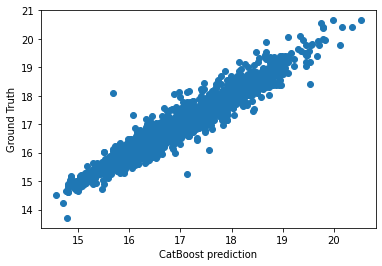

In [61]:
# Plot model performance (done on splitting test data)
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

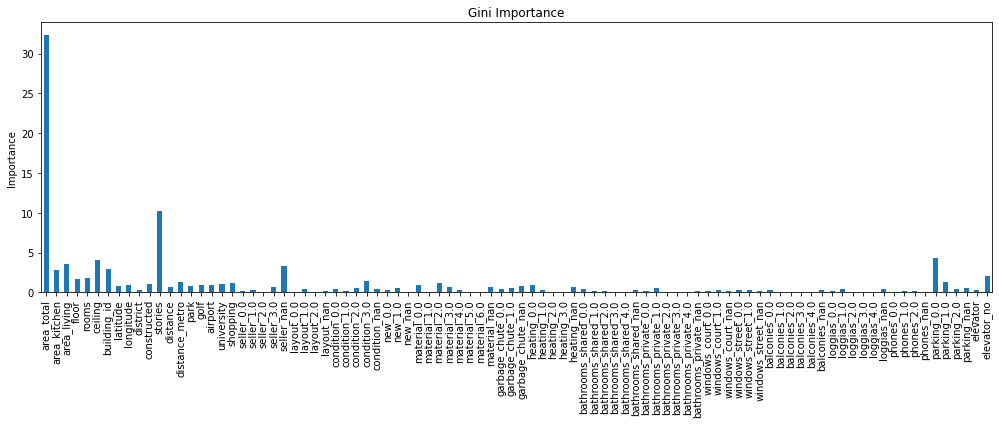

In [62]:
importances = modelCBR.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run CatBoost on category_2

In [63]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [64]:
# Using optimized hyperparameter for complete category_4 data
modelCBR = CatBoostRegressor(
    n_estimators=2026,
    learning_rate=0.07504269029735554,
    thread_count=-1,
    depth=12,
    silent=True,
    random_seed=42,
    bagging_temperature=0.14273452529448316
#     od_type="Iter"
)

modelCBR.fit(X_train, y_train)
cat_prediction = modelCBR.predict(X_test)
cat_mse = round(mean_squared_error(cat_prediction, y_test), 5)
print('Test MSE:', cat_mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.04384


Text(0, 0.5, 'Ground Truth')

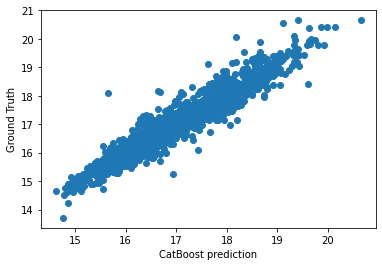

In [65]:
# Plot model performance (done on splitting test data)
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

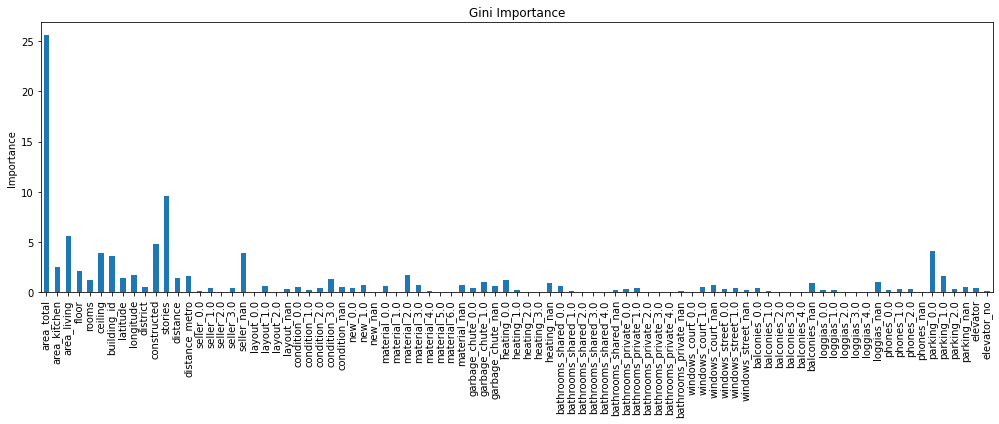

In [66]:
importances = modelCBR.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run XBoost on category_4

In [67]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [68]:
modelXGBR = xgboost.XGBRegressor(base_score=0.7222841777220445, 
                                 booster='gbtree', 
                                 colsample_bylevel=1,
                                 colsample_bynode=1, 
                                 colsample_bytree=0.7022103962052652,
                                 gamma=0, 
                                 gpu_id=-1, 
                                 importance_type=None,
                                 interaction_constraints='',
                                 learning_rate=0.03458425616992177, 
                                 max_delta_step=0,
                                 max_depth=14, 
                                 min_child_weight=7,
                                 monotone_constraints='()', 
                                 n_estimators=2073, 
                                 n_jobs=14,
                                 num_parallel_tree=1, 
                                 predictor='auto', 
                                 random_state=42, 
                                 reg_alpha=0,
                                 reg_lambda=1, 
                                 scale_pos_weight=1, 
                                 subsample=0.8857654154723862, 
                                 tree_method='exact',
                                 validate_parameters=1, 
                                 verbosity=None, 
                                 objective='reg:squarederror',
                                 enable_categorical=False)

modelXGBR.fit(X_train, y_train)
prediction = modelXGBR.predict(X_test)
mse = round(mean_squared_error(predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.04167


Text(0, 0.5, 'Ground Truth')

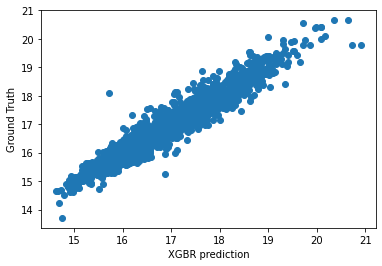

In [69]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('XGBR prediction')
plt.ylabel('Ground Truth')

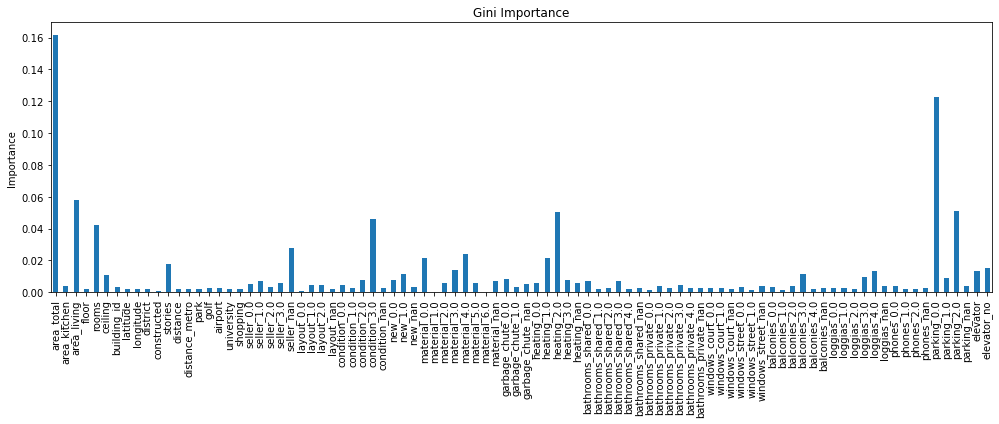

In [70]:
importances = modelXGBR.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run XBoost on category_2

In [71]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [73]:
modelXGBR = xgboost.XGBRegressor(base_score=0.6046105807010513, 
                                 booster='gbtree', 
                                 colsample_bylevel=1,
                                 colsample_bynode=1, 
                                 colsample_bytree=0.7453234659848241,
                                 gamma=0, 
                                 gpu_id=-1, 
                                 importance_type=None,
                                 interaction_constraints='',
                                 learning_rate=0.028564019561400575, 
                                 max_delta_step=0,
                                 max_depth=12, 
                                 min_child_weight=10,
                                 monotone_constraints='()', 
                                 n_estimators=1930, 
                                 n_jobs=14,
                                 num_parallel_tree=1, 
                                 predictor='auto', 
                                 random_state=42, 
                                 reg_alpha=0,
                                 reg_lambda=1, 
                                 scale_pos_weight=1, 
                                 subsample=0.896427989647727, 
                                 tree_method='exact',
                                 validate_parameters=1, 
                                 verbosity=None, 
                                 objective='reg:squarederror',
                                 enable_categorical=False)

modelXGBR.fit(X_train, y_train)
prediction = modelXGBR.predict(X_test)
mse = round(mean_squared_error(predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.03823


Text(0, 0.5, 'Ground Truth')

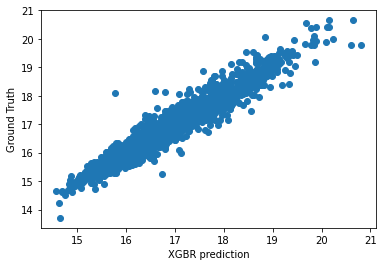

In [74]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('XGBR prediction')
plt.ylabel('Ground Truth')

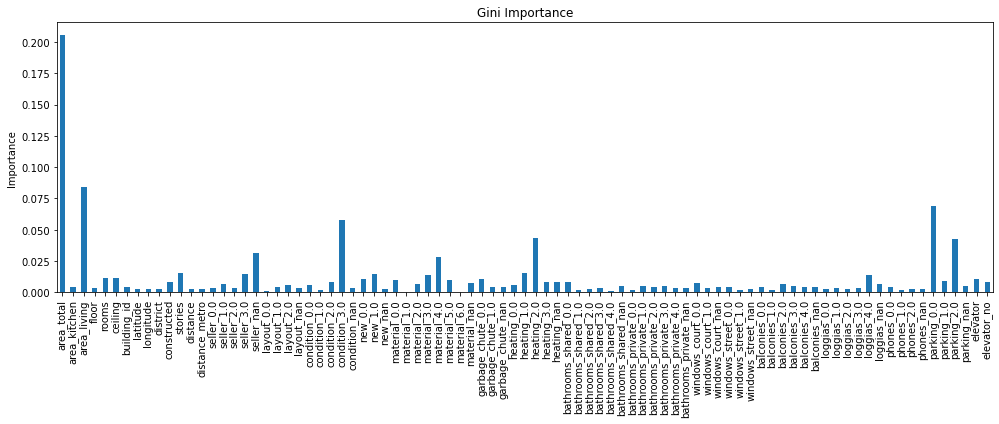

In [75]:
importances = modelXGBR.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run LGBM on category_4

In [76]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [77]:
modelLGBM = lgb.LGBMRegressor(num_leaves=69,
                              max_depth=70, 
                              random_state=42,
                              metric='rmse',
                              n_jobs=3, 
                              n_estimators=3899,
                              colsample_bytree=0.6286990682337588,
                              subsample=0.9798034302267582,
                              learning_rate=0.04200024249047391)

modelLGBM.fit(X_train, y_train)
prediction = modelLGBM.predict(X_test)
mse = round(mean_squared_error(predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.04158


Text(0, 0.5, 'Ground Truth')

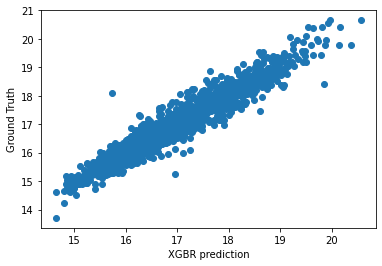

In [78]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

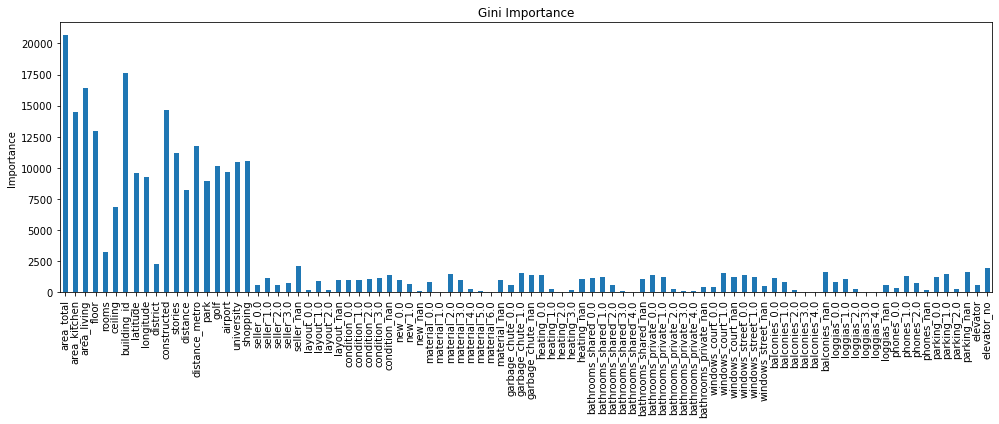

In [79]:
importances = modelLGBM.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run LGBM on category_2

In [84]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [86]:
modelLGBM = lgb.LGBMRegressor(num_leaves=69,
                              max_depth=93, 
                              random_state=42,
                              metric="rmse",
                              n_jobs=7, 
                              n_estimators=4030,
                              colsample_bytree=0.47350585383792243,
                              subsample=0.9160561325493849,
                              learning_rate=0.9160561325493849)

modelLGBM.fit(X_train, y_train)
prediction = modelLGBM.predict(X_test)
mse = round(mean_squared_error(predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.1338


Text(0, 0.5, 'Ground Truth')

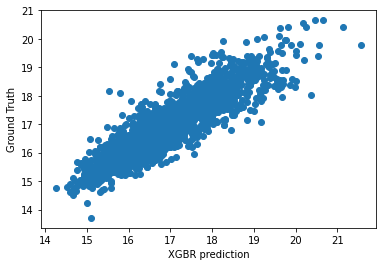

In [87]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

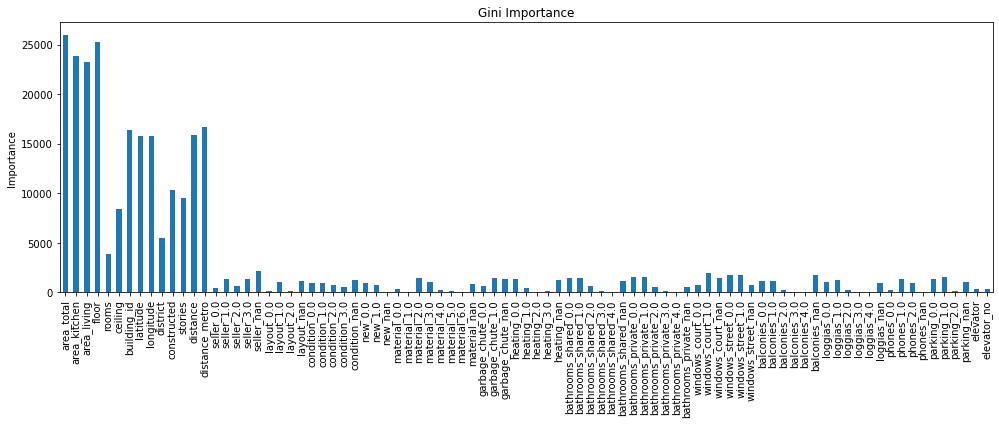

In [88]:
importances = modelLGBM.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run RandomForest on category_4

In [91]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [92]:
modelRF = RandomForestRegressor(n_estimators=304,
                                max_depth=None,
                                #min_samples_split=min_samples_split,
                                #min_samples_leaf=min_samples_leaf,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=8310,
                                min_impurity_decrease=0.0,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=None,
                                random_state=42,
                                verbose=0,
                                warm_start=False,
                                ccp_alpha=0.0,
                                max_samples=None)

modelRF.fit(X_train, y_train)
prediction = modelRF.predict(X_test)
mse = round(mean_squared_error(predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.0638


Text(0, 0.5, 'Ground Truth')

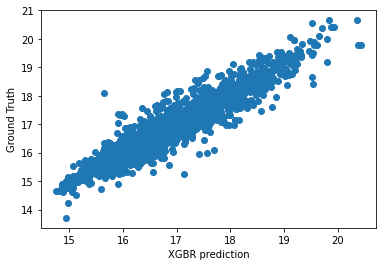

In [93]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('RF prediction')
plt.ylabel('Ground Truth')

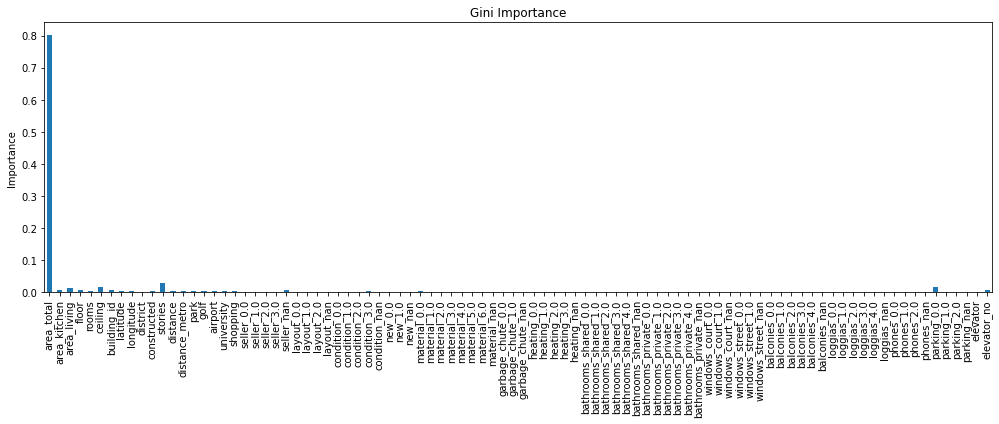

In [94]:
importances = modelRF.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run RandomForest on category_2

In [95]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [96]:
modelRF =RandomForestRegressor(n_estimators=323,
                               max_depth=None,
                               #min_samples_split=min_samples_split,
                               #min_samples_leaf=min_samples_leaf,
                               min_weight_fraction_leaf=0.0,
                               max_features='auto',
                               max_leaf_nodes=7323,
                               min_impurity_decrease=0.0,
                               bootstrap=True,
                               oob_score=False,
                               n_jobs=None,
                               random_state=42,
                               verbose=0,
                               warm_start=False,
                               ccp_alpha=0.0,
                               max_samples=None)

modelRF.fit(X_train, y_train)
prediction = modelRF.predict(X_test)
mse = round(mean_squared_error(predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.06065


Text(0, 0.5, 'Ground Truth')

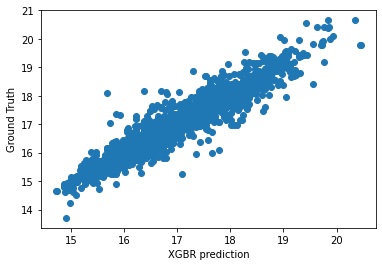

In [97]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('RF prediction')
plt.ylabel('Ground Truth')

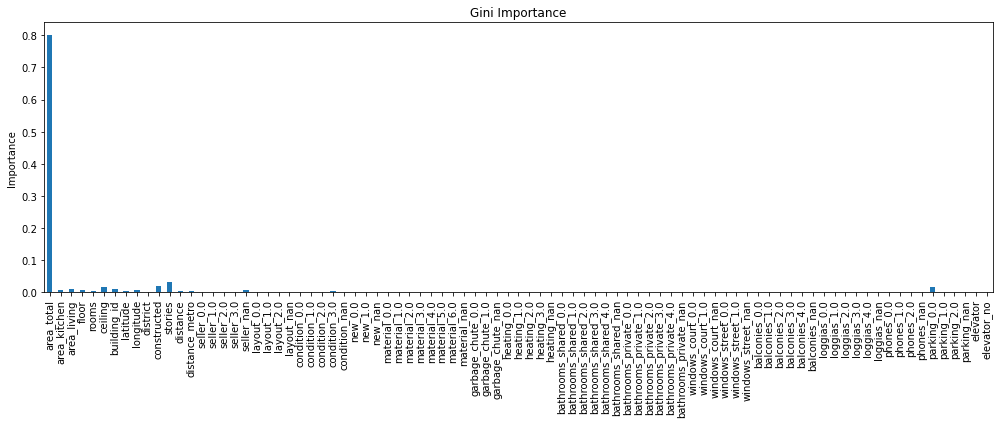

In [98]:
importances = modelRF.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run AdaBoost

# AdaBoost on category_4

In [99]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [100]:
modelADAB = AdaBoostRegressor(n_estimators=784,
                              learning_rate=0.010098229499526408,
                              loss='square',
                              random_state=42)

modelADAB.fit(X_train, y_train)
prediction = modelADAB.predict(X_test)
mse = round(mean_squared_error(predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.1618


Text(0, 0.5, 'Ground Truth')

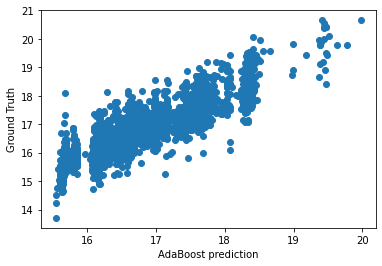

In [101]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('AdaBoost prediction')
plt.ylabel('Ground Truth')

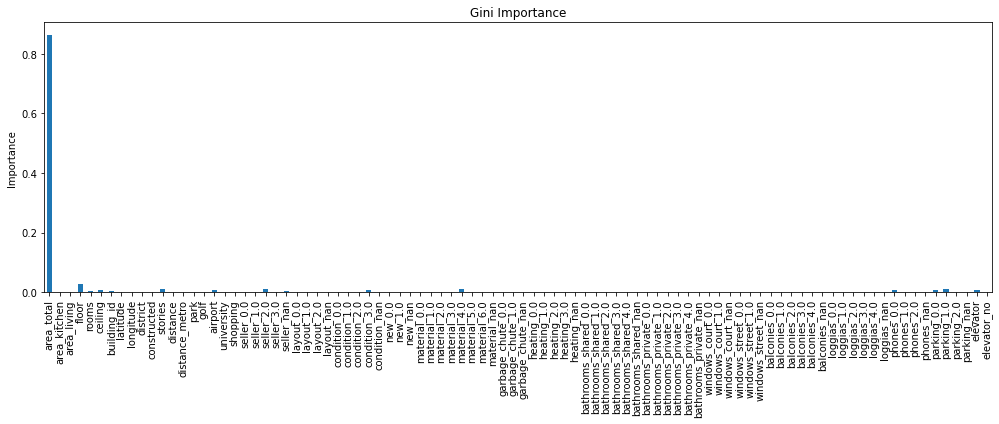

In [102]:
importances = modelADAB.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# AdaBoost on category_2

In [103]:
X = D2_train.copy()
y = y_train_2.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [104]:
modelADAB = AdaBoostRegressor(n_estimators=719,
                              learning_rate=0.015963876207044078,
                              loss='square',
                              random_state=42)

modelADAB.fit(X_train, y_train)
prediction = modelADAB.predict(X_test)
mse = round(mean_squared_error(predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.15789


Text(0, 0.5, 'Ground Truth')

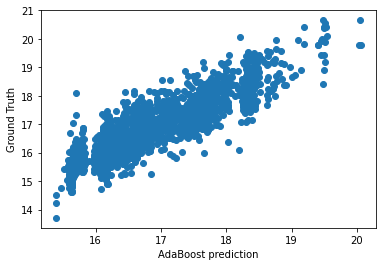

In [105]:
# Plot model performance (done on splitting test data)
plt.scatter(prediction, y_test)
plt.xlabel('AdaBoost prediction')
plt.ylabel('Ground Truth')

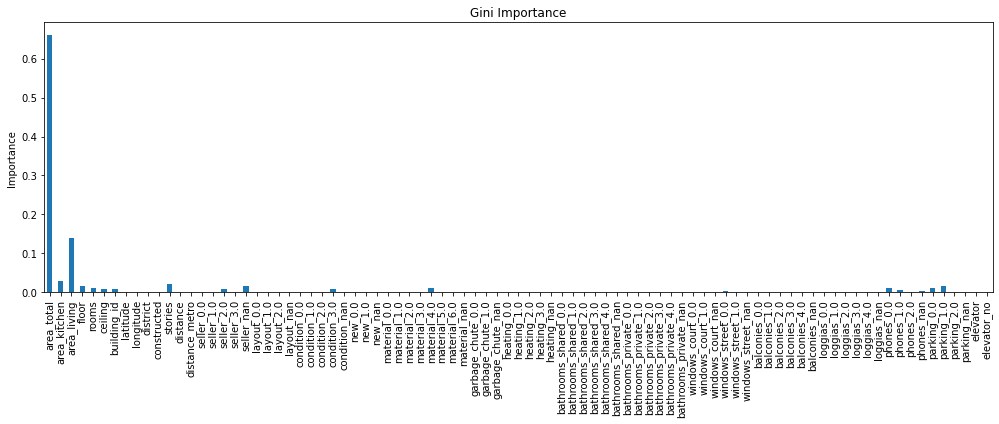

In [106]:
importances = modelADAB.feature_importances_
importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# True Stacking using category_4 data

In [126]:
X = D4_train.copy()
y = y_train_4.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [127]:
# Settings from Vlads notebook

ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS,
           shuffle=True,
           random_state=SEED
           ) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [128]:
# Test META_MODEL splitting training data

X_train2 = X_train.copy()
X_test2 = X_test.copy()
y_train2 = y_train.copy()
X_train2 = X_train2.to_numpy()
X_test2 = X_test2.to_numpy()
y_train2 = y_train2.to_numpy().ravel()

# Use my optimized on complete category_4 data
lgbm_regressor = lgb.LGBMRegressor(num_leaves=69,
                                   max_depth=70, 
                                   random_state=42,
                                   metric='rmse',
                                   n_jobs=3, 
                                   n_estimators=3899,
                                   colsample_bytree=0.6286990682337588,
                                   subsample=0.9798034302267582,
                                   learning_rate=0.04200024249047391)

dt_oof_train, dt_oof_test = get_oof(lgbm_regressor, X_train2, y_train2, X_test)
print('All predictions for train set:', len(dt_oof_train))
print('All predictions for test set:', len(dt_oof_test))

All predictions for train set: 18628
All predictions for test set: 4657


In [129]:
# Use my optimized models on complete category_4 data

xgboost_regressor = xgboost.XGBRegressor(base_score=0.7222841777220445, 
                                         booster='gbtree', 
                                         colsample_bylevel=1,
                                         colsample_bynode=1, 
                                         colsample_bytree=0.7022103962052652,
                                         gamma=0, 
                                         gpu_id=-1, 
                                         importance_type=None,
                                         interaction_constraints='',
                                         learning_rate=0.03458425616992177, 
                                         max_delta_step=0,
                                         max_depth=14, 
                                         min_child_weight=7,
                                         monotone_constraints='()', 
                                         n_estimators=2073, 
                                         n_jobs=14,
                                         num_parallel_tree=1, 
                                         predictor='auto', 
                                         random_state=42, 
                                         reg_alpha=0,
                                         reg_lambda=1, 
                                         scale_pos_weight=1, 
                                         subsample=0.8857654154723862, 
                                         tree_method='exact',
                                         validate_parameters=1, 
                                         verbosity=None, 
                                         objective='reg:squarederror',
                                         enable_categorical=False)


catboost_regressor = CatBoostRegressor(n_estimators=1567,
                                       learning_rate=0.07896645553926333,
                                       thread_count=-1,
                                       depth=9,
                                       silent=True,
                                       random_seed=42,
                                       bagging_temperature=0.2641942678718098
                                       # od_type="Iter"
                                       )

rf_regressor = RandomForestRegressor(n_estimators=304,
                                     max_depth=None,
                                     #min_samples_split=min_samples_split,
                                     #min_samples_leaf=min_samples_leaf,
                                     min_weight_fraction_leaf=0.0,
                                     max_features='auto',
                                     max_leaf_nodes=8310,
                                     min_impurity_decrease=0.0,
                                     bootstrap=True,
                                     oob_score=False,
                                     n_jobs=None,
                                     random_state=42,
                                     verbose=0,
                                     warm_start=False,
                                     ccp_alpha=0.0,
                                     max_samples=None)

In [130]:
test_data = X_test.copy()

lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train2, y_train2, test_data)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train2, y_train2, test_data)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train2, y_train2, test_data)
rf_oof_train, rf_oof_test = get_oof(rf_regressor, X_train2, y_train2, test_data)

In [131]:
x_train = np.concatenate((
    lgbm_oof_train,
    xgb_oof_train,
    cat_oof_train,
    rf_oof_train
), axis=1)

x_test = np.concatenate((
    lgbm_oof_test,
    xgb_oof_test,
    cat_oof_test,
    rf_oof_test
), axis=1)

In [132]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=5,
    max_depth=7, 
    random_state=SEED, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=200,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.05)

META_MODEL.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=1, learning_rate=0.05, max_depth=7, metric='mse',
              n_estimators=200, n_jobs=4, num_leaves=5, random_state=42,
              subsample=0.9)

In [133]:
final_predictions = META_MODEL.predict(x_test)

In [135]:
print(final_predictions)

[16.79055283 15.94495133 16.04371046 ... 16.80632886 15.70311854
 16.10622942]


In [145]:
mse = round(mean_squared_error(final_predictions, y_test), 5)
print('Test MSE:', mse)
print("Test RMSE: ", np.sqrt(mse))

Test MSE: 0.04085
Test RMSE:  0.20211382931407737


Text(0, 0.5, 'Ground Truth')

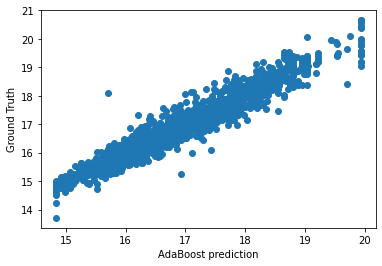

In [138]:
# Plot model performance (done on splitting test data)
plt.scatter(final_predictions, y_test)
plt.xlabel('AdaBoost prediction')
plt.ylabel('Ground Truth')

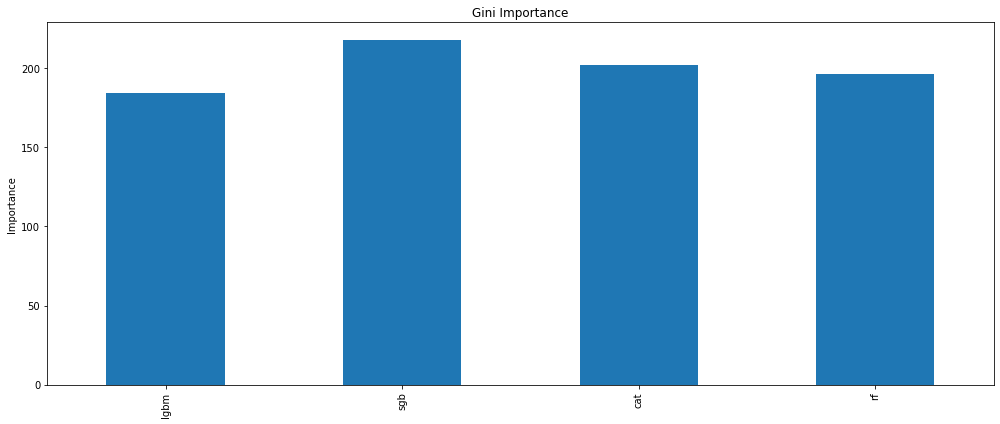

In [140]:
importances = META_MODEL.feature_importances_
importances = pd.Series(importances, index=["lgbm", "sgb", "cat", "rf"])

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# Run META_MODEL on training data

In [146]:
# Run on complete data 
X_train = D4_train.copy()
X_test = D4_test.copy()
y_train = y_train_4.copy()

In [147]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS,
           shuffle=True,
           random_state=SEED
           ) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [148]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()
y_train2 = y_train.copy()
X_train2 = X_train2.to_numpy()
X_test2 = X_test2.to_numpy()
y_train2 = y_train2.to_numpy().ravel()

# Use my optimized on complete category_4 data
lgbm_regressor = lgb.LGBMRegressor(num_leaves=69,
                                   max_depth=70, 
                                   random_state=42,
                                   metric='rmse',
                                   n_jobs=3, 
                                   n_estimators=3899,
                                   colsample_bytree=0.6286990682337588,
                                   subsample=0.9798034302267582,
                                   learning_rate=0.04200024249047391)

dt_oof_train, dt_oof_test = get_oof(lgbm_regressor, X_train2, y_train2, X_test)
print('All predictions for train set:', len(dt_oof_train))
print('All predictions for test set:', len(dt_oof_test))

All predictions for train set: 23285
All predictions for test set: 9937


In [149]:
# Use my optimized models on complete category_4 data

xgboost_regressor = xgboost.XGBRegressor(base_score=0.7222841777220445, 
                                         booster='gbtree', 
                                         colsample_bylevel=1,
                                         colsample_bynode=1, 
                                         colsample_bytree=0.7022103962052652,
                                         gamma=0, 
                                         gpu_id=-1, 
                                         importance_type=None,
                                         interaction_constraints='',
                                         learning_rate=0.03458425616992177, 
                                         max_delta_step=0,
                                         max_depth=14, 
                                         min_child_weight=7,
                                         monotone_constraints='()', 
                                         n_estimators=2073, 
                                         n_jobs=14,
                                         num_parallel_tree=1, 
                                         predictor='auto', 
                                         random_state=42, 
                                         reg_alpha=0,
                                         reg_lambda=1, 
                                         scale_pos_weight=1, 
                                         subsample=0.8857654154723862, 
                                         tree_method='exact',
                                         validate_parameters=1, 
                                         verbosity=None, 
                                         objective='reg:squarederror',
                                         enable_categorical=False)


catboost_regressor = CatBoostRegressor(n_estimators=1567,
                                       learning_rate=0.07896645553926333,
                                       thread_count=-1,
                                       depth=9,
                                       silent=True,
                                       random_seed=42,
                                       bagging_temperature=0.2641942678718098
                                       # od_type="Iter"
                                       )

rf_regressor = RandomForestRegressor(n_estimators=304,
                                     max_depth=None,
                                     #min_samples_split=min_samples_split,
                                     #min_samples_leaf=min_samples_leaf,
                                     min_weight_fraction_leaf=0.0,
                                     max_features='auto',
                                     max_leaf_nodes=8310,
                                     min_impurity_decrease=0.0,
                                     bootstrap=True,
                                     oob_score=False,
                                     n_jobs=None,
                                     random_state=42,
                                     verbose=0,
                                     warm_start=False,
                                     ccp_alpha=0.0,
                                     max_samples=None)

In [150]:
test_data = X_test.copy()

lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train2, y_train2, test_data)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train2, y_train2, test_data)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train2, y_train2, test_data)
rf_oof_train, rf_oof_test = get_oof(rf_regressor, X_train2, y_train2, test_data)

In [151]:
x_train = np.concatenate((
    lgbm_oof_train,
    xgb_oof_train,
    cat_oof_train,
    rf_oof_train
), axis=1)

x_test = np.concatenate((
    lgbm_oof_test,
    xgb_oof_test,
    cat_oof_test,
    rf_oof_test
), axis=1)

In [152]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=5,
    max_depth=7, 
    random_state=SEED, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=200,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.05)

META_MODEL.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=1, learning_rate=0.05, max_depth=7, metric='mse',
              n_estimators=200, n_jobs=4, num_leaves=5, random_state=42,
              subsample=0.9)

In [153]:
# Using complete category_4 dataset optimizing lgbm, cat, rf, xboost and true-stack set up 
# with META_MODEL
# Kaggle score: 0.28466

# Models test performance locally was:
# Test MSE: 0.04085
# Test RMSE:  0.20211382931407737

kaggle_predictions = META_MODEL.predict(x_test)

In [159]:
from sklearn.metrics import mean_squared_log_error

In [157]:
submission = pd.DataFrame(df_test_4["id"])
submission["price_prediction"] =  np.exp(kaggle_predictions)
submission.to_csv("predictions_META_MODEL.csv", index=False)

In [158]:
df = pd.read_csv("predictions_META_MODEL.csv")
df.shape
df.head()

,id,price_prediction
0,23285,1.674793e+07
1,23286,1.391260e+07
2,23287,6.687208e+06
3,23288,9.726257e+06
4,23289,6.210826e+06
